# **Authors: Davy SIMEU, Romin DURAND, Joyce TCHAMDJOU**

# Import des librairies

In [3]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Récupération des données

## Utilitaires / Routines

In [126]:
def char_to_index(char):
    ascii = ord(char)
    if 48 <= ascii <= 57: # 0, 1, ..., 9
        return ascii-48
    elif 65 <= ascii <= 90: # A, B, ..., Z
        return ascii-65+10
    elif 97 <= ascii <= 122: # a, b, ..., z
        return ascii-97 + 10
    else:
        print('Error: {} is not a digit or a letter'.format(char))
        return -1

def index_to_char(index):
    if 0 <= index <= 9: # Digits
        return str(index)
    elif 10 <= index <= 35: # Letters
        return str(chr(index-10+65))

def plot_random_sample_of_each_char(X, n_sample_per_char=39, height=20, width=16, ncol=3):
    n, _ = X.shape
    if n%n_sample_per_char != 0:
        print('Warning: first dimension of X should be '
              + 'a multiple of n_sample_per_char={}'.format(n_sample_per_char))

    n_char = n//n_sample_per_char
    nrow = n_char//ncol + int(n_char%ncol>0)
    fig, axs = plt.subplots(nrow, ncol)
    for i in range(nrow*ncol):
        if nrow==1:
            ax = axs[i%ncol]
        else:
            ax = axs[i//ncol,i%ncol]

        if i < n_char:
            rand_ind = np.random.randint(i*n_sample_per_char, (i+1)*n_sample_per_char)
            rand_char = X[rand_ind]
            img = rand_char.reshape(height, width)
            ax.matshow(img)
            ax.axis('off')
        else:
            fig.delaxes(ax)

    plt.tight_layout()
    
def plot_err(err_history):
    plt.figure(figsize=(13, 7))
    plt.plot(err_history)
    plt.xlabel('Epochs')
    plt.ylabel('Reconstruction error (RMSE)')
    plt.show()

Dans cette partie, on implémente la fonction ``lire_alpha_digit`` permettant de récupérer les données souhaitées au bon format.

In [83]:
def lire_alpha_digit(characters, n_sample_per_char=39, height=20, width=16):
    f = scipy.io.loadmat('binaryalphadigs.mat')
    data = f['dat']

    char_indices = [char_to_index(char) for char in characters if char_to_index(char)!=-1]
    char_indices = np.unique(char_indices)

    N_char = len(char_indices)
    n = n_sample_per_char*N_char
    p = height*width 

    X = np.zeros((n, p))
    for i, idx in enumerate(char_indices):
        for j in range(n_sample_per_char):
            k = i*n_sample_per_char + j
            line = data[idx, j].flatten()
            X[k] = line

    return X

## Exemple de chargement de données

shape of X: (234, 320)


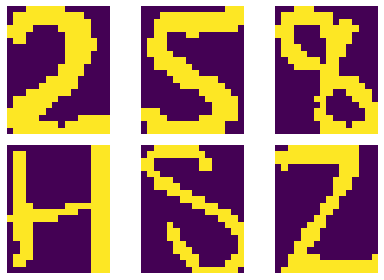

In [84]:
X = lire_alpha_digit('258SHZ')
print('shape of X: {}'.format(X.shape))
plot_random_sample_of_each_char(X)

# Création de la classe RBM

In [280]:
class RBM():
    def __init__(self, p, q, var=1e-2):
        self.a = np.zeros(p)
        self.b = np.zeros(q)
        self.W = np.random.normal(0, 1, size=(p, q))*np.sqrt(var)
        self.q = q
        self.p = p

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def entree_sortie(self, X):
        return self.sigmoid(X @ self.W + self.b)

    def sortie_entree(self, H):
        return self.sigmoid(H @ self.W.T + self.a)

    def train(self, X, lr=1e-1, batch_size=13, nb_epoch=10, height=20, width=16, epoch_per_plot=1, verbose=True):
        if verbose:
            print("Beginning training of the RBM...")
        n, p = X.shape
        err_history = []
        for epoch in range(nb_epoch):
            np.random.shuffle(X)
            
            for batch in range(0, n, batch_size):
                X_batch = X[batch:min(batch+batch_size, n)]
                current_bs = X_batch.shape[0]

                # Calcul de v_0, v_1, p(v|h) et p(h|v)
                v_0 = X_batch 
                ph_v_0 = self.entree_sortie(v_0) 
                h_0 = (np.random.random((current_bs, self.q)) < ph_v_0).astype(int) 
                pv_h_0 = self.sortie_entree(h_0) 
                v_1 = (np.random.random((current_bs, p)) < pv_h_0).astype(int) 
                ph_v_1 = self.entree_sortie(v_1) 

                # Calcul du gradient (des dérivées partielles)
                grad_a = np.sum(v_0 - v_1, axis=0) 
                grad_b = np.sum(ph_v_0 - ph_v_1, axis=0) 
                grad_W = v_0.T @ ph_v_0 - v_1.T @ ph_v_1

                # Mise à jour des paramètres
                self.W += lr/current_bs * grad_W
                self.a += lr/current_bs * grad_a
                self.b += lr/current_bs * grad_b

            H = self.entree_sortie(X)
            X_rec = self.sortie_entree(H)

            err = np.mean((X-X_rec)**2)**.5
            err_history.append(err)                
                
            if epoch % epoch_per_plot == 0 and verbose:
                print('Epoch {}/{} - RMSE: {:.4f}'.format(epoch+1, nb_epoch, err))
                rand_idx = np.random.randint(n)
                original_img = X[rand_idx].reshape(height, width)
                reconstructed_img = X_rec[rand_idx].reshape(height, width)
                
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 2))
                ax1.imshow(original_img)
                ax1.axis('off')
                ax1.set_title("Original")
                
                ax2.imshow(reconstructed_img)
                ax2.axis('off')
                ax2.set_title("Reconstructed")
                fig.suptitle("Epoch {}".format(epoch+1))
                plt.tight_layout()
                plt.show()

        return err_history

    def generate(self, nb_iter, thresh=.5, height=20, width=16, ncol=5, nrow=2):
        p, q = self.W.shape
        nb_images = nrow*ncol

        _, axs = plt.subplots(nrow, ncol, figsize=(10, 5))
        for i in range(nb_images):
            v = (np.random.random(p) < thresh).astype(int)
            for _ in range(nb_iter):
                ph_v = self.entree_sortie(v) 
                h = (np.random.random(q) < ph_v).astype(int)
                pv_h = self.sortie_entree(h)
                v = (np.random.random(p) < pv_h).astype(int)

            image = v.reshape(height, width)
            axs[i//ncol, i%ncol].imshow(image)
            axs[i//ncol, i%ncol].axis('off')
        plt.tight_layout()
        
        
    def show_filter(self, height=20, ncol=5, nrow=2):
        idxs = np.random.randint(self.q, size=ncol*nrow)
        plt.figure(figsize=(10, 5))
        for i, idx in enumerate(idxs):
            weights = self.W[:, idx]
            filter = weights.reshape(height, self.p//height)
            
            plt.subplot(nrow, ncol, i+1)
            plt.axis('off')
            plt.imshow(filter, cmap='Greys')
        plt.tight_layout()

# Utilisation du modèle et analyse
Nous pouvons maintenant entrainer le modèle et étudier son comportement

Dimension des données d'entrées : 320 

Beginning training of the RBM...
Epoch 1/1000 - RMSE: 0.4340


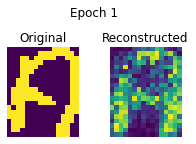

Epoch 101/1000 - RMSE: 0.0497


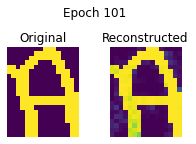

Epoch 201/1000 - RMSE: 0.0228


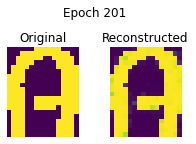

Epoch 301/1000 - RMSE: 0.0152


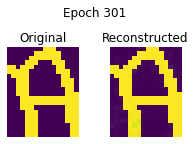

Epoch 401/1000 - RMSE: 0.0111


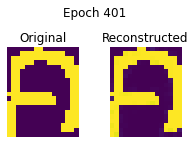

Epoch 501/1000 - RMSE: 0.0089


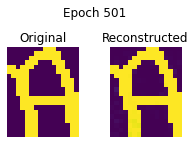

Epoch 601/1000 - RMSE: 0.0073


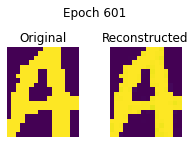

Epoch 701/1000 - RMSE: 0.0063


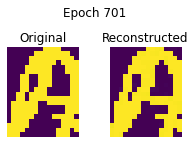

Epoch 801/1000 - RMSE: 0.0055


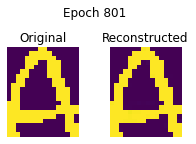

Epoch 901/1000 - RMSE: 0.0049


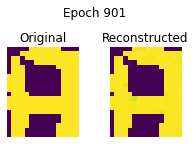

In [160]:
X = lire_alpha_digit('A')
_, p = X.shape
print("Dimension des données d'entrées :", p, "\n")

my_rbm0 = RBM(p, q=256)
err_history0 = my_rbm0.train(X, nb_epoch=1000, lr=1e-1, epoch_per_plot=100)

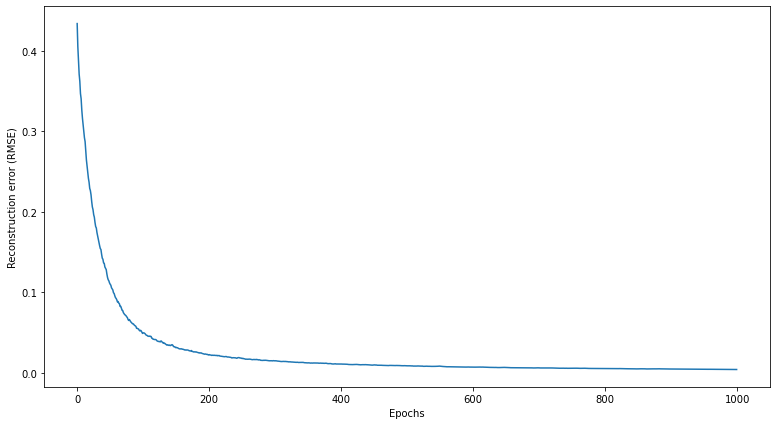

In [161]:
plot_err(err_history0)

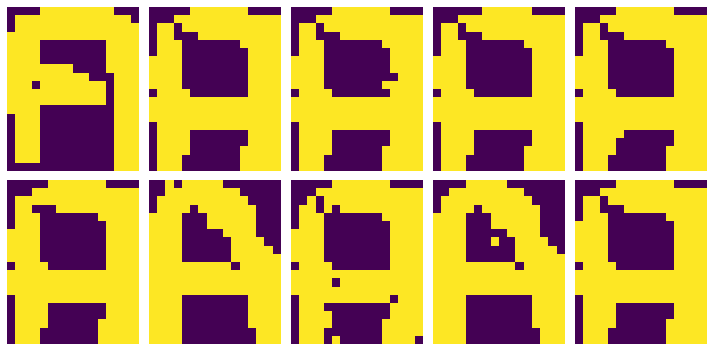

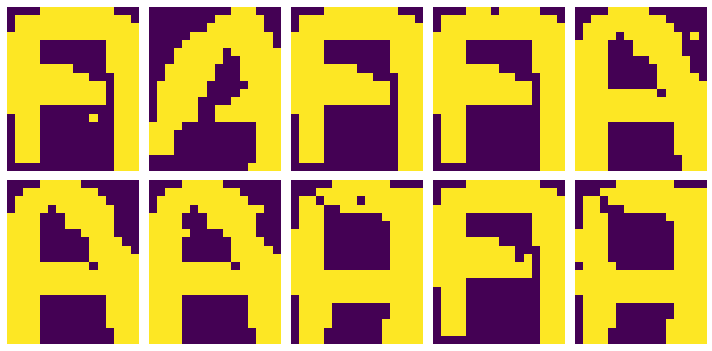

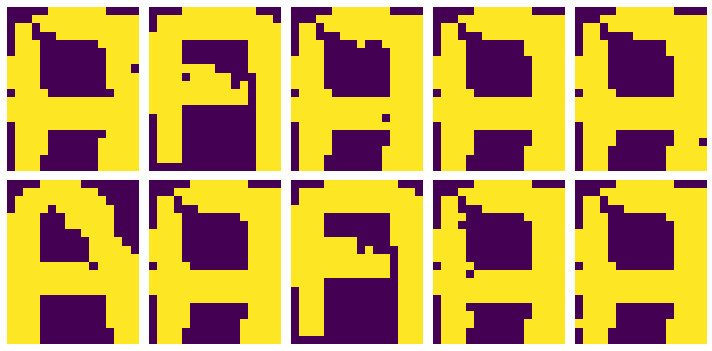

In [165]:
my_rbm0.generate(nb_iter=10)

In [50]:
lr = 1e-1
lrs = [lr*10, lr, lr/10, lr/100, lr/1000, lr/10000]
err_lr = []
for el in lrs:
    my_rbm_ = RBM(p, q=256)
    err_history = my_rbm_.train(X, nb_epoch=500, lr=el, epoch_per_plot=100, verbose=False)
    err_lr.append(err_history)

Beginning training of the RBM...
Beginning training of the RBM...
Beginning training of the RBM...
Beginning training of the RBM...
Beginning training of the RBM...
Beginning training of the RBM...


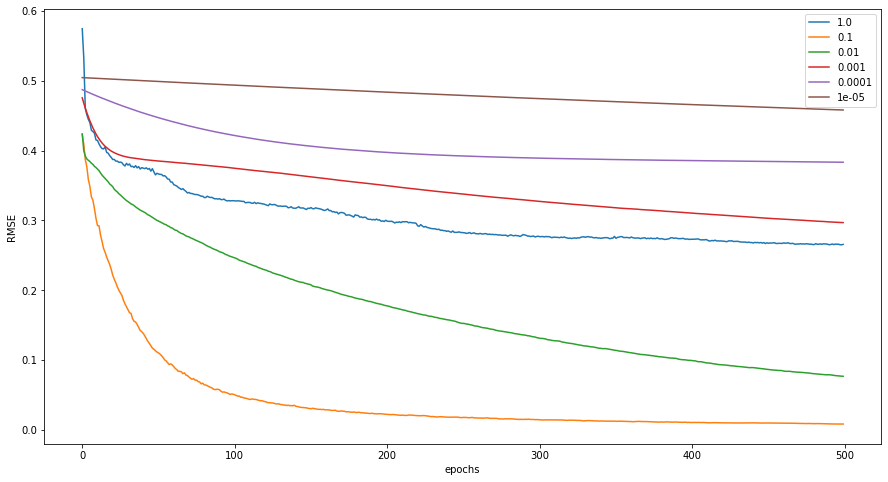

In [51]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err_lr):
    plt.plot(el, label=lrs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

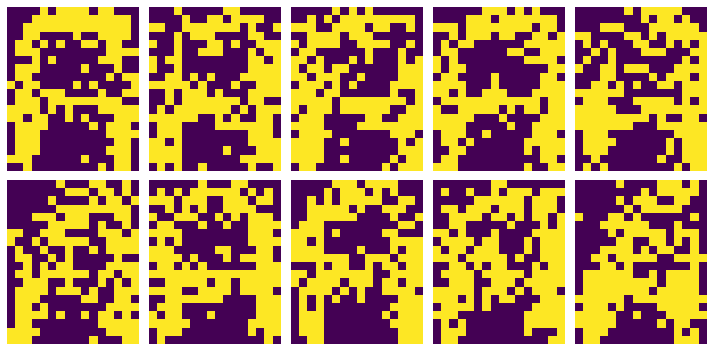

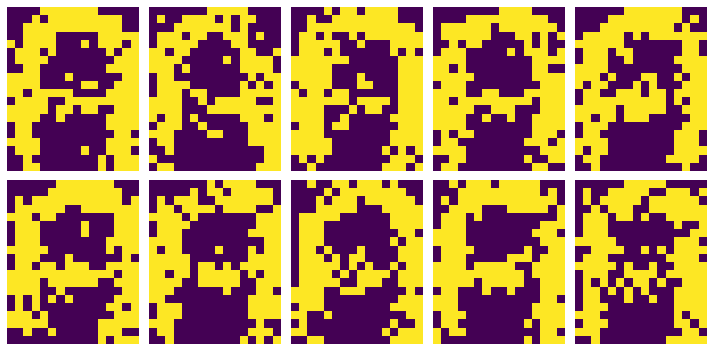

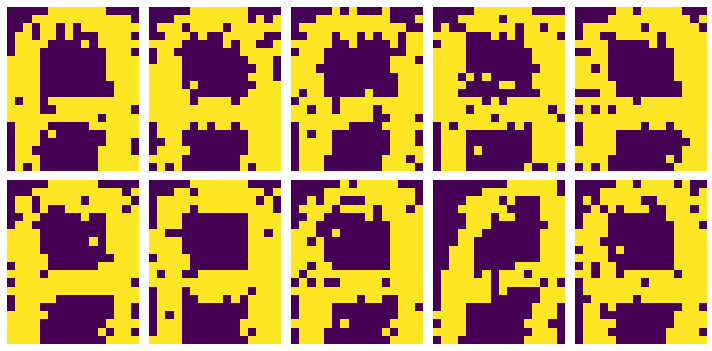

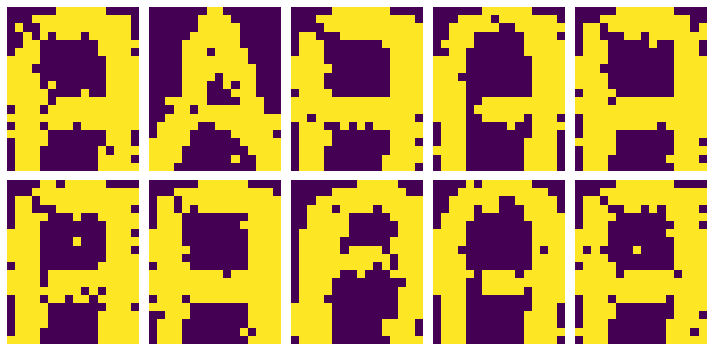

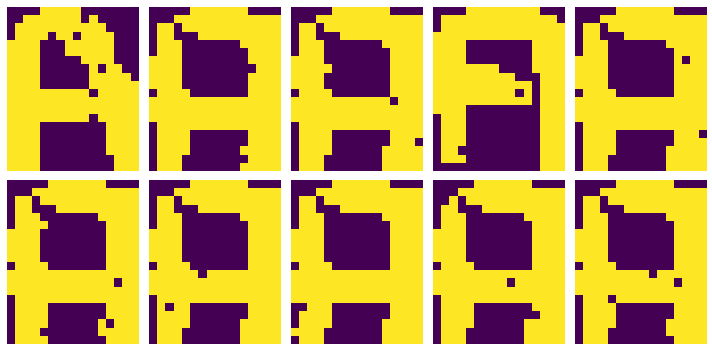

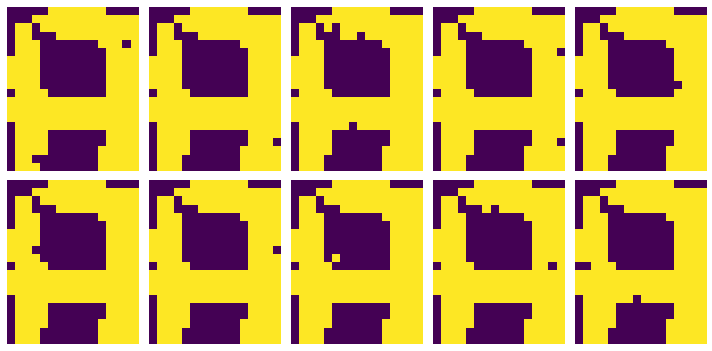

In [166]:
ep = 5
epochs = [ep, ep*2, ep*10, ep*20, ep*100, ep*200]
err_ep = []
for el in epochs:
    my_rbm_ = RBM(p, q=256)
    err_history = my_rbm_.train(X, nb_epoch=el, lr=1e-1, epoch_per_plot=100, verbose=False)
    err_ep.append(err_history)
    my_rbm_.generate(nb_iter=10)

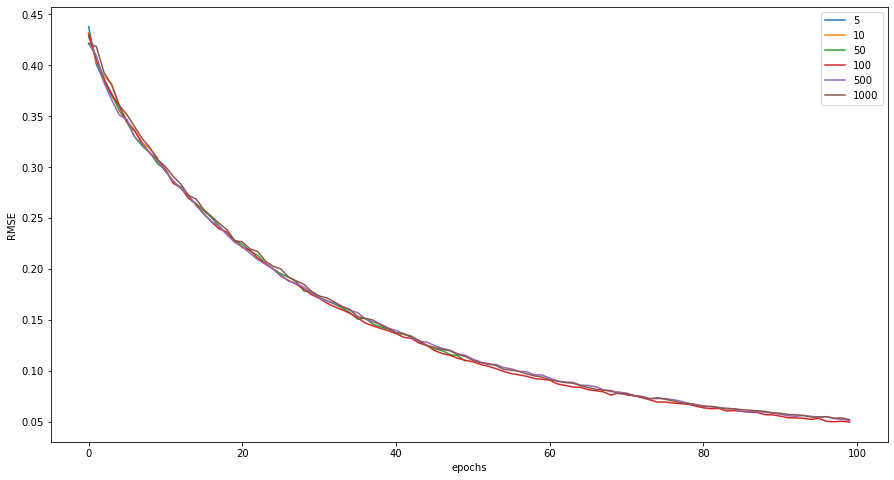

In [167]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err_ep):
    plt.plot(el[:100], label=epochs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [168]:
lr = 32
qs = [lr, lr*2, lr*4, lr*8, lr*16, lr*32]
err_q = []
for el in qs:
  my_rbm_ = RBM(p, q=el)
  err_history = my_rbm_.train(X, nb_epoch=500, lr=1e-1, epoch_per_plot=100, verbose=False)
  err_q.append(err_history)

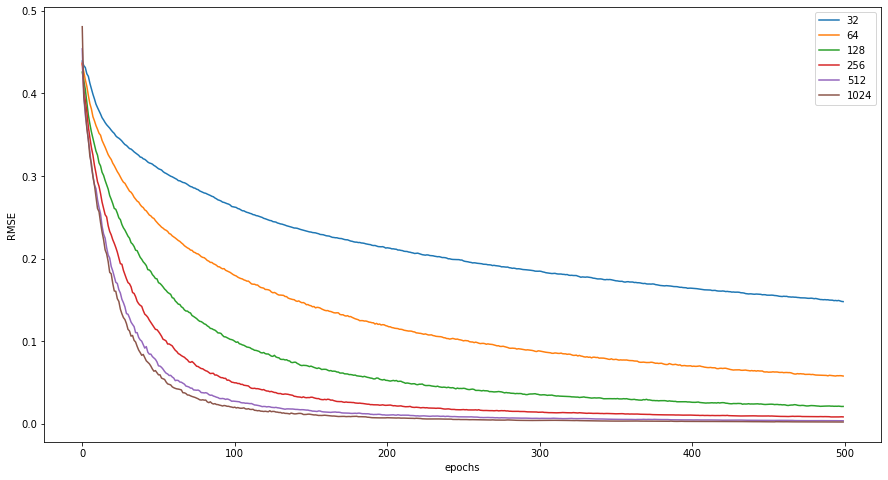

In [169]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err_q):
    plt.plot(el, label=qs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Quand on prête attention aux filtres (le filtre étant la matrice des poids d'une unité donnée) du RBM

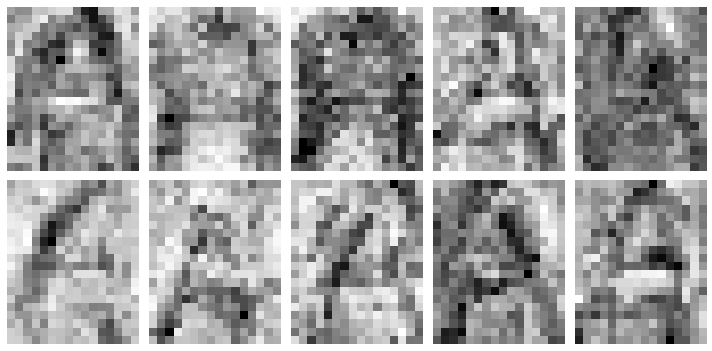

In [170]:
my_rbm0.show_filter()

# MNIST

In [218]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
print("Original dimensions train_X: {}".format(train_X.shape))
print("Original dimensions test_X: {}\n".format(test_X.shape))
print("Original dimensions train_y: {}".format(train_y.shape))
print("Original dimensions test_y: {}".format(test_y.shape))


N_train = train_X.shape[0]
N_test = test_X.shape[0]
size = train_X.shape[1]*train_X.shape[2]

train_X = train_X.reshape(N_train, size)
test_X = test_X.reshape(N_test, size)
print("Flattened dimensions train_X: {}".format(train_X.shape))
print("Flattened dimensions test_X: {}\n".format(test_X.shape))

thresh = 100
X_ = np.vstack((train_X, test_X))
X_ = (X_>thresh).astype(int) 
y = np.hstack((train_y, test_y))
print("Full flattened dataset dimensions: {}".format(X_.shape))
print("Full label set dimensions: {}".format(y.shape))

Original dimensions train_X: (60000, 28, 28)
Original dimensions test_X: (10000, 28, 28)

Original dimensions train_y: (60000,)
Original dimensions train_y: (10000,)
Flattened dimensions train_X: (60000, 784)
Flattened dimensions test_X: (10000, 784)

Full flattened dataset dimensions: (70000, 784)
Full label set dimensions: (70000,)


In [226]:
def select_digits_mnist(digits):
    mask = (y == digits[0])
    for label in digits[1:]:
        mask |= (y == label)
    return X_[mask], y[mask]

0 samples with label 0
0 samples with label 1
0 samples with label 2
7141 samples with label 3
0 samples with label 4
0 samples with label 5
0 samples with label 6
0 samples with label 7
0 samples with label 8
0 samples with label 9


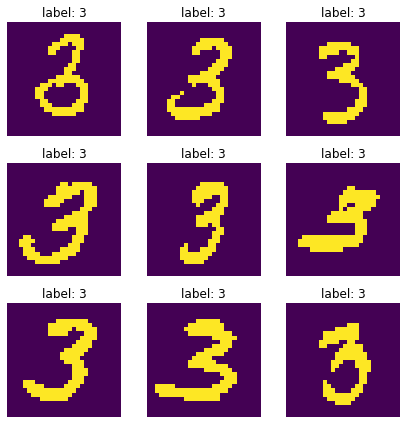

In [250]:
X_train_rbm, y_train_rbm = select_digits_mnist([8])

for digit in range(10):
    print('{} samples with label {}'.format(sum(y_train_rbm == digit), digit))
n, _ = X_train_rbm.shape
nrow = 3
ncol = nrow

fig, axs = plt.subplots(nrow, ncol, figsize=(6, 6))
for i in range(nrow*ncol):
    ax = axs[i//ncol, i%ncol]
    rand_idx = np.random.randint(n)
    rand_sample = X_train_rbm[rand_idx]
    rand_sample = rand_sample.reshape(28, 28)
    ax.imshow(rand_sample)
    ax.axis('off')
    ax.set_title('label: {}'.format(y_train_rbm[rand_idx]))
plt.tight_layout()

Beginning training of the RBM...
Epoch 1/100 - RMSE: 0.2331


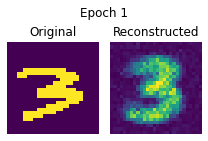

Epoch 11/100 - RMSE: 0.1847


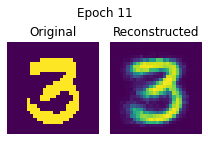

Epoch 21/100 - RMSE: 0.1696


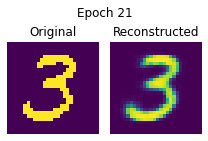

Epoch 31/100 - RMSE: 0.1604


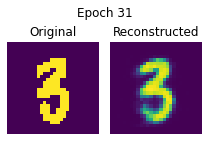

Epoch 41/100 - RMSE: 0.1548


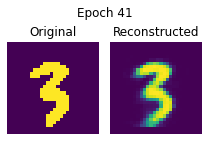

Epoch 51/100 - RMSE: 0.1502


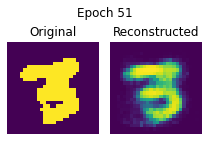

Epoch 61/100 - RMSE: 0.1464


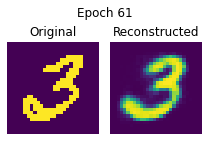

Epoch 71/100 - RMSE: 0.1435


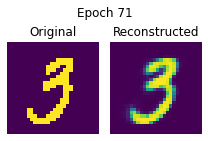

Epoch 81/100 - RMSE: 0.1404


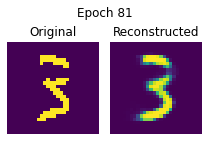

Epoch 91/100 - RMSE: 0.1385


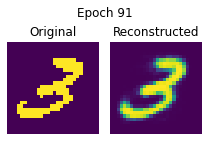

In [251]:
_, p = X_train_rbm.shape

my_rbm1 = RBM(p, q=512)
err_history = my_rbm1.train(X_train_rbm, nb_epoch=100, batch_size=2048, lr=1e-1, height=28, width=28, epoch_per_plot=10)

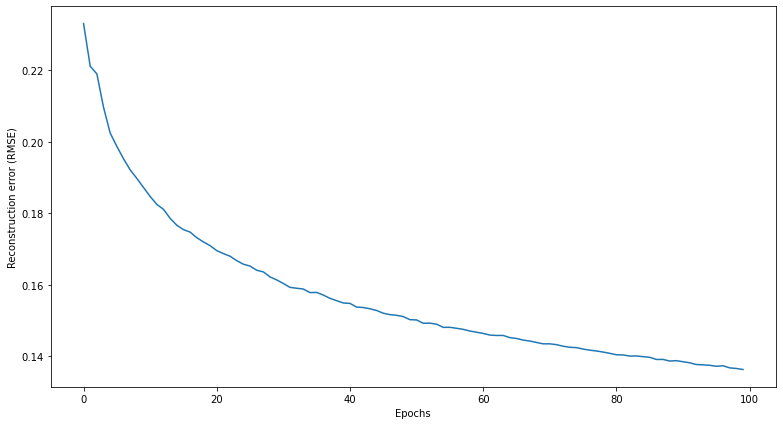

In [252]:
plot_err(err_history)

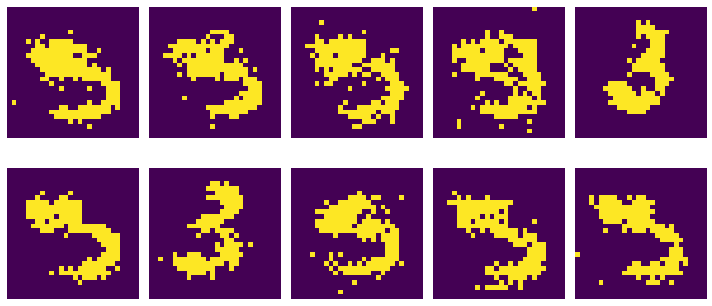

In [253]:
my_rbm1.generate(nb_iter=1000, thresh=.5, height=28, width=28)

# Création de la classe DBN

In [281]:
class DBN():
    def __init__(self, sizeRBMs, var=1e-2):
        self.L = len(sizeRBMs)-1
        self.layers = [RBM(sizeRBMs[i], sizeRBMs[i+1], var) for i in range(self.L)]

    def pretrain(self, X, lr=1e-1, batch_size=13, nb_epoch=10, height=20, width=16, verbose=False):
        for l in range(self.L):
            _ = self.layers[l].train(X, lr, batch_size, nb_epoch, height, width, verbose=verbose)
            X = self.layers[l].entree_sortie(X)

    def entree_sortie(self, X):
        H = X.copy()
        for l in range(self.L):
            H = self.layers[l].entree_sortie(H)
        return H

    def sortie_entree(self, H):
        X = H.copy()
        for l in range(self.L):
            X = self.layers[-l-1].sortie_entree(X)
        return X

    def generate(self, nb_iter, thresh=.5, height=20, width=16, ncol=5, nrow=2):
        p = self.layers[0].p
        q = self.layers[-1].q
        nb_images = nrow*ncol

        _, axs = plt.subplots(nrow, ncol, figsize=(10, 5))
        
        for i in range(nb_images):
            v = (np.random.random(p) < thresh).astype(int)
            for _ in range(nb_iter):
                ph_v = self.entree_sortie(v) 
                h = (np.random.random(q) < ph_v).astype(int)
                pv_h = self.sortie_entree(h)
                v = (np.random.random(p) < pv_h).astype(int)

            image = v.reshape(height, width)
            axs[i//ncol, i%ncol].imshow(image)
            axs[i//ncol, i%ncol].axis('off')
        plt.tight_layout()

In [291]:
X_dnn = lire_alpha_digit('ABEF486')
_, p = X_dnn.shape

my_dbn = DBN([p, 160, 640, 280])
my_dbn.pretrain(X_dnn, nb_epoch=1000, lr=1e-1)

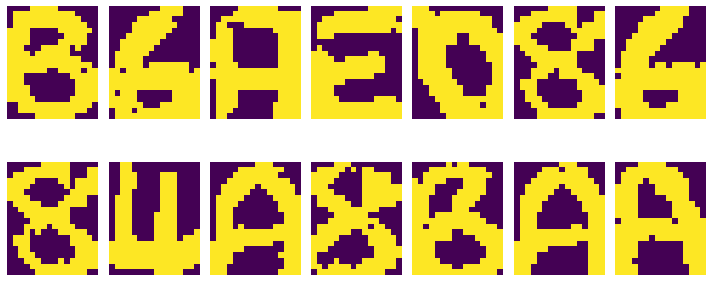

In [359]:
my_dbn.generate(nb_iter=100, ncol=7)

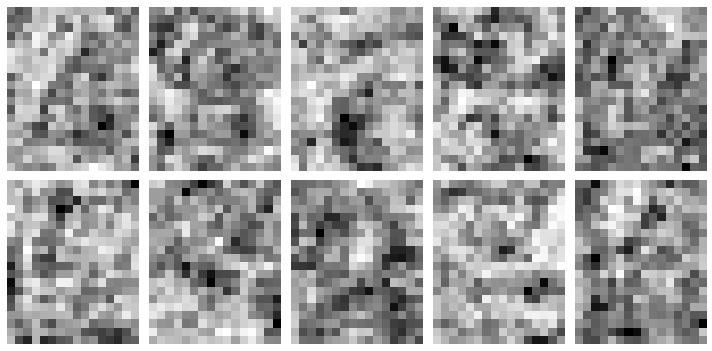

In [400]:
my_dbn.layers[0].show_filter()

Le DBN réussit à capturer la variabilité de l'ensemble d'apprentissage étant donné qu'après entraînement il génère plusieurs caractères différents (parmi ceux appris bien sûr)

In [296]:
# Essayons de générer à l'aide du seul RBM
my_rbm = RBM(p, 512)
_ = my_rbm.train(X_dnn, nb_epoch=1000, lr=1e-1, epoch_per_plot=100, verbose=False)

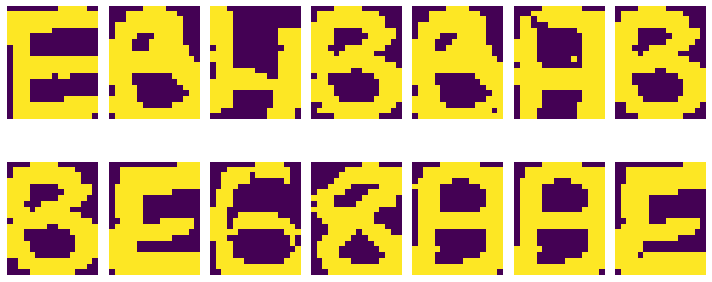

In [381]:
my_rbm.generate(nb_iter=100, ncol=7)

Visiblement le RBM aussi reussit bien à capturer l'exhaustivité de l'ensemble d'apprentissage.... C'est surprenant et bizarre !

# Création de la classe DNN

In [ ]:
class DNN():
    def __init__(self, n_classes, dim_layers=None, dbn=None):
        self.n_classes = n_classes
        if dbn is not None:
            self.dbn = dbn
            self.classifier = RBM(dbn.layers[-1].q, n_classes)
            self.n_layers = dbn.L
        elif dim_layers is not None:
            self.dbn = DBN(dim_layers)
            self.classifier = RBM(dim_layers[-1], n_classes)
            self.n_layers = len(self.dbn.layers)
        else:
            print("Error: you need to either define dim_layers (list of weights dimensions) or load a pretrained dbn")
            
    def compute_softmax(self, X):
        return np.exp(X-X.max())/np.exp(X-X.max()).sum()
    
    def entree_sortie(self, X):
        tab = []
        for i in self.n_layers:
            X = self.dbn.layers[i].entree_sortie(X)
            tab.append(X)
        
        X = self.classifier.entree_sortie(X)
        probs = self.compute_softmax(X)
        
        return tab, probs
        
    def backpropagate(self, X, y, lr=1e-1, batch_size=2048, nb_epoch=100, height=28, width=28, verbose=False):
        losses = []
        for epoch in range(nb_epoch):
            print(f"Epoch {epoch}/{nb_epoch}")
            outputs, y_hat = self.entree_sortie(X)
            print(len(outputs))
            nllloss = -np.sum(y * np.log(y_hat))
            losses.append(nllloss)
            dW = y_hat - y @ outputs[-1].T
            db = y_hat - y
            self.classifier.W -= dW
            self.classifier.b -= db
            
            for i in range (self.n_layers):
                dW = np.sum(dW @ self.dbn.layers[-i-1].W @ (outputs[-i-2] * (1-outputs[-i-2])))    